# Imports    

In [28]:
try:
    import mne
except ModuleNotFoundError:    
    ! pip install mne[hdf5]
try:
    import autoreject
except ModuleNotFoundError:
    ! pip install autoreject

import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import pandas as pd
import os

In [29]:
HOME = os.getcwd()
FILE1 = os.path.join(HOME, 'first.csv')
FILE2 = os.path.join(HOME, 'second.csv')

# helper functions

In [30]:
# function to convert to our csv data to mne package
DEFAULT_BASELINE = (None, 5)
def csv_to_mne(df, sampling_rate=1000, montage_type:str=None, use_baseline=False, baseline=None, drop_last_n=None):
    if montage_type is None:
        montage_type = 'biosemi32'

    if baseline is None:
        baseline = DEFAULT_BASELINE
    # first set the montage
    montage = mne.channels.make_standard_montage(montage_type)
    # extract the names from the montage
    ch_names = list(montage.get_positions()["ch_pos"].keys())
    # we assume all electrodes are EEG
    types = ["eeg"] * 32
    # create a mne_info object to use with MNE data
    mne_info = mne.create_info(
        ch_names=ch_names, ch_types=types, sfreq=sampling_rate, verbose=False
    )
    
    # drop the last n sample if the 'drop_last_n' argument is set to a non-None value
    if isinstance(drop_last_n, int):
        df = df.iloc[:, :-drop_last_n]        

    data = mne.io.RawArray(df, mne_info, verbose=False)
    
    if use_baseline:
        data._data = mne.baseline.rescale(data._data, times=data.times, baseline=baseline)
    
    data.set_montage(montage)
    return data, ch_names 


In [31]:
def filter_mne(mne_data, low=1, high=40):
    return mne_data.copy().filter(l_freq=low, h_freq=high)

# we will do that through visualizing the filter mne data
import matplotlib.pyplot as plt
PLOTS = ['sensors', 'topomap', 'psd', 'general']

def plot_mne_data(mne_data, plot_types = None, show_names=False):
    if plot_types is None: 
        plot_types = PLOTS 

    data_psd = mne_data.compute_psd()
    if "sensors" in plot_types:
        mne_data.plot_sensors(show_names=show_names)
    if "general" in plot_types:
        mne_data.plot()
    if "topomap" in plot_types:
        data_psd.plot_topomap(show_names=show_names)
    if "psd" in plot_types:
        data_psd.plot(show_names=show_names)
    
    plt.show()

In [32]:
def plot_windows(mne_data, start=0, end=None, windows_size=0.5, picks=None):
    if picks is None:
        picks = 'all'

    if end is None:
        end = mne_data.times[-1]
    
    t = start
    counter = 1
    while t < end:
        
        copy = mne_data.copy()        
        # first extract the data in that specific windown
        data = copy.crop(tmin=t, tmax=min(t + windows_size, end), verbose=False)
        # compute psd and plot the topomap        
        data_psd = data.compute_psd()
        fig = data_psd.plot_topomap(show_names=True, show=False)        
        # set the figure's size
        fig.set_size_inches((16, 9))
 
        # set the title
        plt.title(f"{t} -- {min(t + windows_size, end)}")
 
        # save the plot
        plt.savefig(os.path.join(HOME, f'windows_n_{counter}'))
        # display the image
        plt.show()
        # # clear plt
        # plt.clf()

        # update the pointer
        t = min(t + windows_size, end)
        counter += 1

In [33]:
import numpy as np
def auc(x: list[int], t: list[int]):
    assert len(x) == len(t)
    # first consider the differences between the timestamps
    t_copy = list(t).copy()
    t_copy.insert(0, 0)
    dts = np.ediff1d(t_copy)
    return sum(np.abs(np.multiply(x, dts)))

def extract_channels(mne_data, channels_names: list[str]):
    # first create the corresponding object using the mne.pick_channels function
    wanted_channels = mne.pick_channels(mne_data.info['ch_names'], include=channels_names)
    print(wanted_channels) # indices of the channels to keep
    # use the wanted channels to create an info object for mne object creation
    info_object = mne.pick_info(mne_data.info, wanted_channels)
    # let's create the mne object
    new_data = mne_data._data[wanted_channels, :] # extract the channels: slice the rows, not the columns
    return mne.io.RawArray(new_data, info_object, verbose=False)


In [34]:
def plot_psd(mne_data, ch_names, fmin=1, fmax=45, show=True, figsize=None, all_one=False):
    if figsize is None:
        figsize = (12, 12)
    assert len(ch_names) == len(mne_data._data)
    # first calculate the power spectral density using the multitaper method
    psd, freqs = mne.time_frequency.psd_array_multitaper(mne_data._data, sfreq=mne_data.info['sfreq'], fmin=fmin, fmax=fmax, verbose=False)
    # let's calculate the mean over the channels
    # psd_over_channels = np.mean(psd, axis=0)
    # print(psd_over_channels.shape)
    
    if show: 
        if all_one:
            for index, ch_n in enumerate(ch_names):
                plt.plot(freqs, psd[index], label=ch_n)        
            plt.legend()
        else:
            figure , axis = plt.subplots(nrows= psd.shape[0], figsize=figsize)
            for index, ch_n in enumerate(ch_names):
                axis[index].plot(freqs, psd[index, :])
                axis[index].set_title(f"psd of {ch_n} channel")
                axis[index].set_xlabel('frequencies Hz')
                axis[index].set_ylabel('power P')
                axis[index].set_xticks(np.linspace(fmin, fmax, (fmax - fmin + 1)))

        plt.show()

    return psd, freqs


In [35]:
DELTA = [0, 4]
THETA = [4, 8]
ALPHA = [8, 12]
BETA = [12, 30]
GAMMA = [30, 45]
def frequecy_ranges(psd, freqs):
    assert len(psd) == len(freqs)
    ranges_ratio = dict(zip(['delta', 'theta', 'alpha', 'beta', 'gamma'], [[] for _ in range(5)]))
    for p, f in zip(psd, freqs):
        if DELTA[0] <= f <= DELTA[1]:
            ranges_ratio['delta'].append(p) 
        elif THETA[0] <= f <= THETA[1]:
            ranges_ratio['theta'].append(p)
        elif ALPHA[0] <= f <= ALPHA[1]:
            ranges_ratio['alpha'].append(p)
        elif BETA[0] <= f <= BETA[1]:
            ranges_ratio['beta'].append(p)
        else:
            ranges_ratio['gamma'].append(p)
    
    for freq_range, f in ranges_ratio.items():
        print(f'The range {freq_range}: {round(sum(f) / sum(psd) * 100, 3)} % of the total power')



In [36]:

# READ THE INITIAL DATA
df1 = pd.read_csv(FILE1, header=None)
df2 = pd.read_csv(FILE2, header=None)
# conver to mne data objects
mne1, ch_names= csv_to_mne(df1, use_baseline=True, drop_last_n=12)
mne2, ch_names= csv_to_mne(df2, use_baseline=True, drop_last_n=12)

mne1_org = mne1.copy()
mne2_org = mne2.copy()

# Read the data and extract the significant channels

In [37]:
# READ THE INITIAL DATA
df1 = pd.read_csv(FILE1, header=None)
df2 = pd.read_csv(FILE2, header=None)
# convert to mne data objects
mne1, ch_names= csv_to_mne(df1, use_baseline=True, drop_last_n=12)
mne2, ch_names= csv_to_mne(df2, use_baseline=True)
# make a copy 
mne1_org = mne1.copy()
mne2_org = mne2.copy()

# apply low and high pass filtering
m1 = filter_mne(mne1)
m2 = filter_mne(mne2)

## File 1: extracting the key 

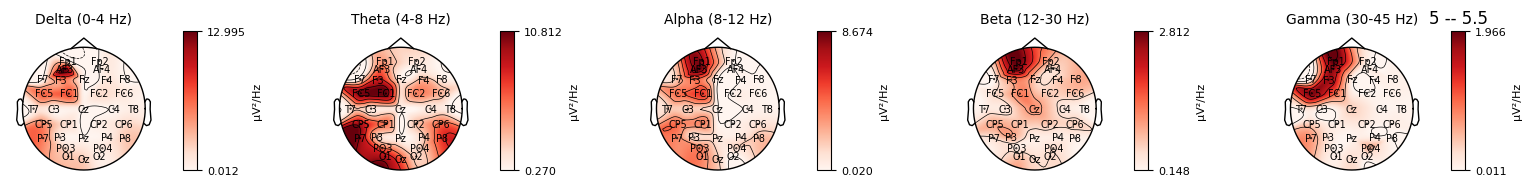

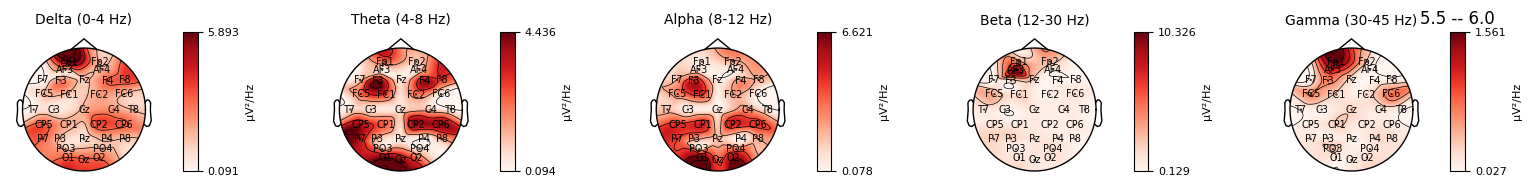

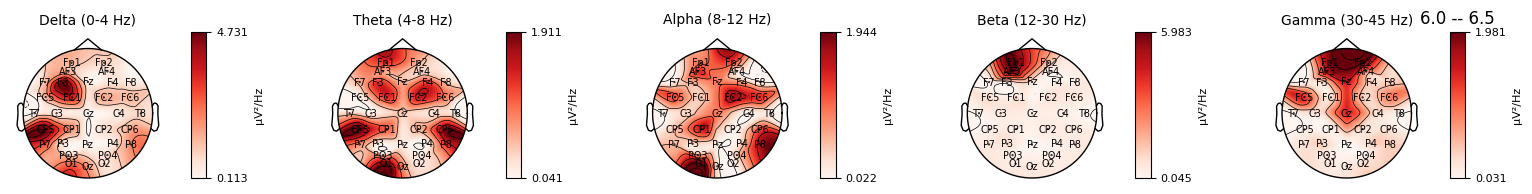

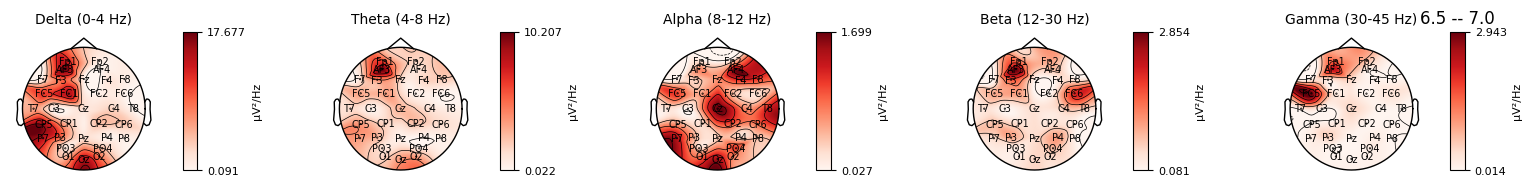

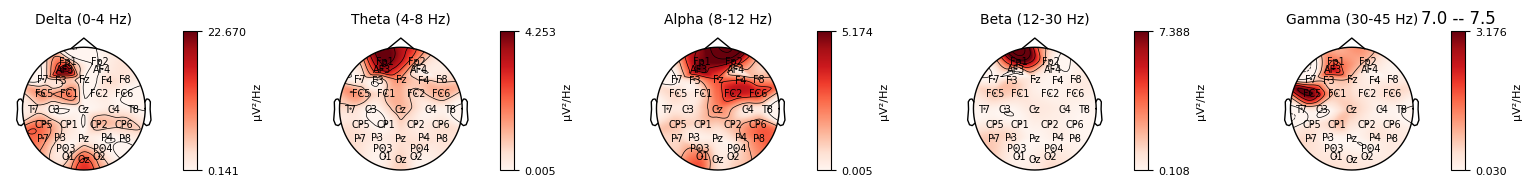

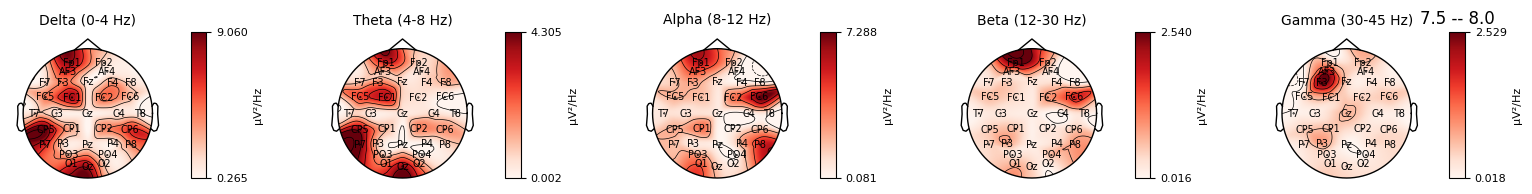

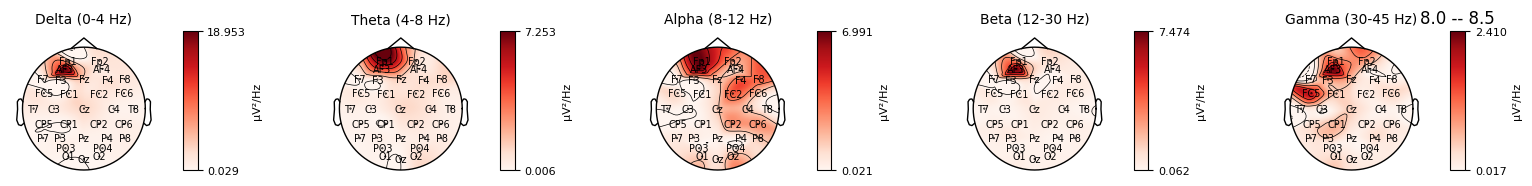

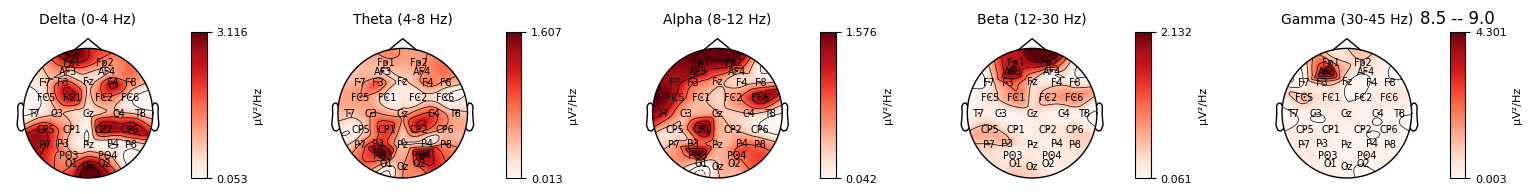

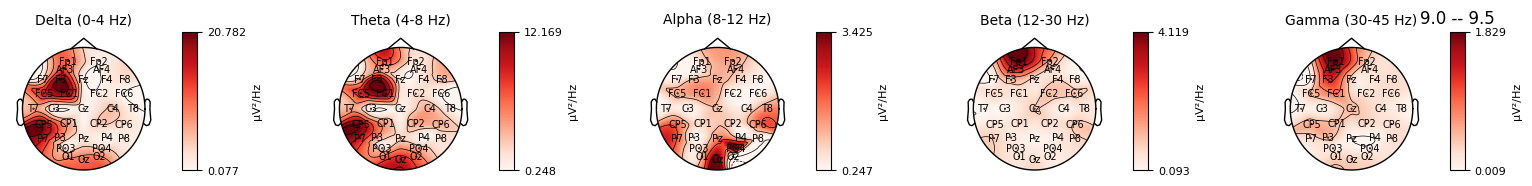

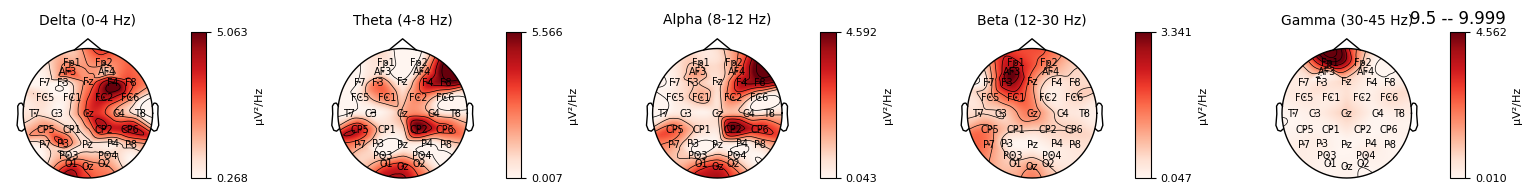

In [38]:
plot_windows(m1, start=5) # starting from the 5-th second (because the first 5 seconds are baseline)

Visualizing the signals' intensities gives us a rough idea on the most significant / key channels. The active channels can be clusted into groups. Mainly:
1. Fp1, AF3
2. CP5, P7, P3
3. O1, Oz, O2

I decided not to consider any channels on the Motor Function Area as it is responsible for eye movement and orientation, according to: 
![image info](brain_view.png)

Let's consider some measurements to support the conclusions reached from the visualizations. The area under the curve might be a good quantitative measure of a channel activity as it reflects both variance and magnitude of the signal with slightly more desired properities:
1. Signals with extremely high or extremely low variance would have relatively smaller AUC
2. intensity of the signals play a major role in AUC as well.

In [39]:
# extracting data after the first 5 seconds
m1_5 = mne1.copy().crop(tmin=5)
areas = pd.Series(np.apply_along_axis(lambda x: auc(x, m1_5.times), 1, m1_5._data), index=ch_names)
areas.sort_values()

C3     0.000015
T8     0.000016
Pz     0.000017
F7     0.000019
P4     0.000020
T7     0.000020
PO3    0.000021
AF4    0.000023
C4     0.000024
PO4    0.000024
P8     0.000025
F8     0.000028
CP1    0.000028
O2     0.000028
Fz     0.000029
FC2    0.000030
O1     0.000030
FC6    0.000030
F4     0.000030
CP6    0.000031
CP2    0.000031
Cz     0.000031
P3     0.000031
Oz     0.000033
P7     0.000035
CP5    0.000036
Fp2    0.000037
FC1    0.000038
FC5    0.000040
F3     0.000041
Fp1    0.000059
AF3    0.000064
dtype: float64

Using The visualizations and the results of calculating the Area under the curve, we can conclude that AF3 and Fp1 are the channels representing the key activity of the brain.

In [40]:
# let's consider the correlation between the chosen channels:
channels_1 = ['AF3', 'Fp1', 'F3']
m1_new = extract_channels(m1_5, channels_1)
df_data = pd.DataFrame(m1_new._data, index=channels_1)
df_data.T.corr()

[0 1 3]


AF3       Fp1        F3
AF3  1.000000  0.256146  0.255368
Fp1  0.256146  1.000000  0.236250
F3   0.255368  0.236250  1.000000

The low pair-wise correlation between channels suggests that none of these channels are redundant, and thus should be considered in the rest of the analysis.

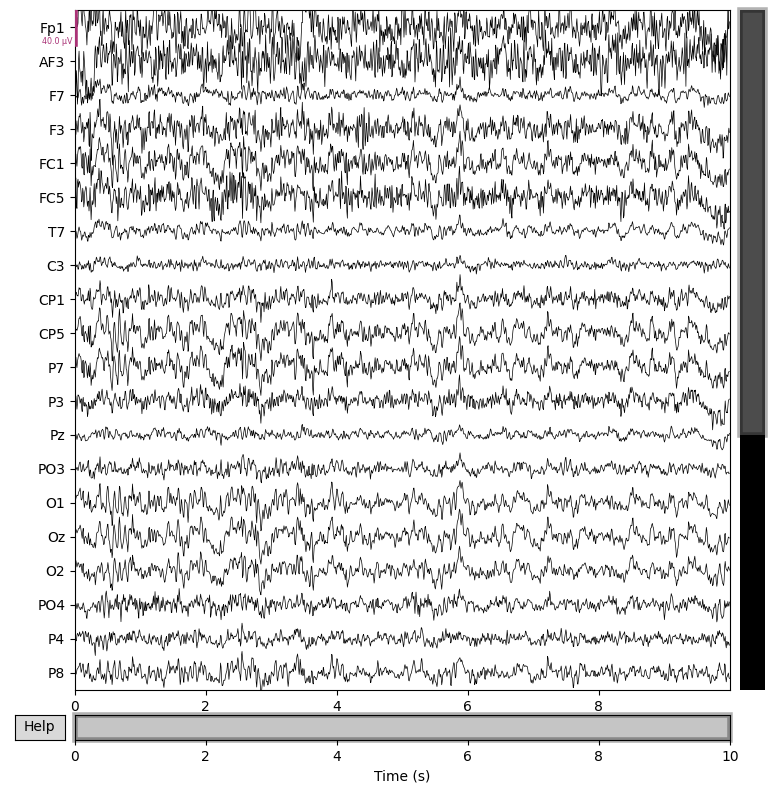

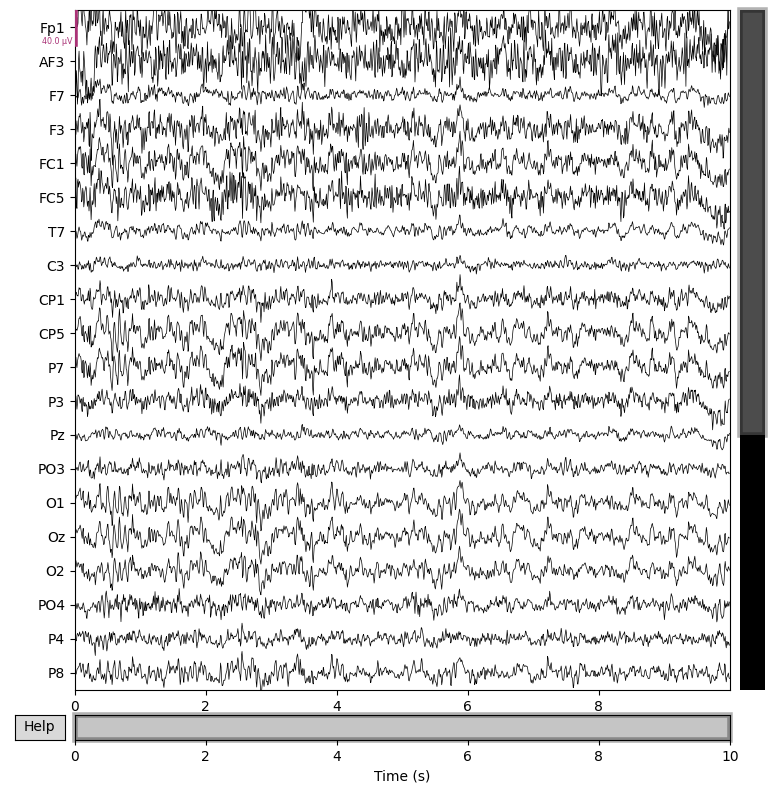

In [41]:
# let's visualize the actual oscillations
m1.plot() 

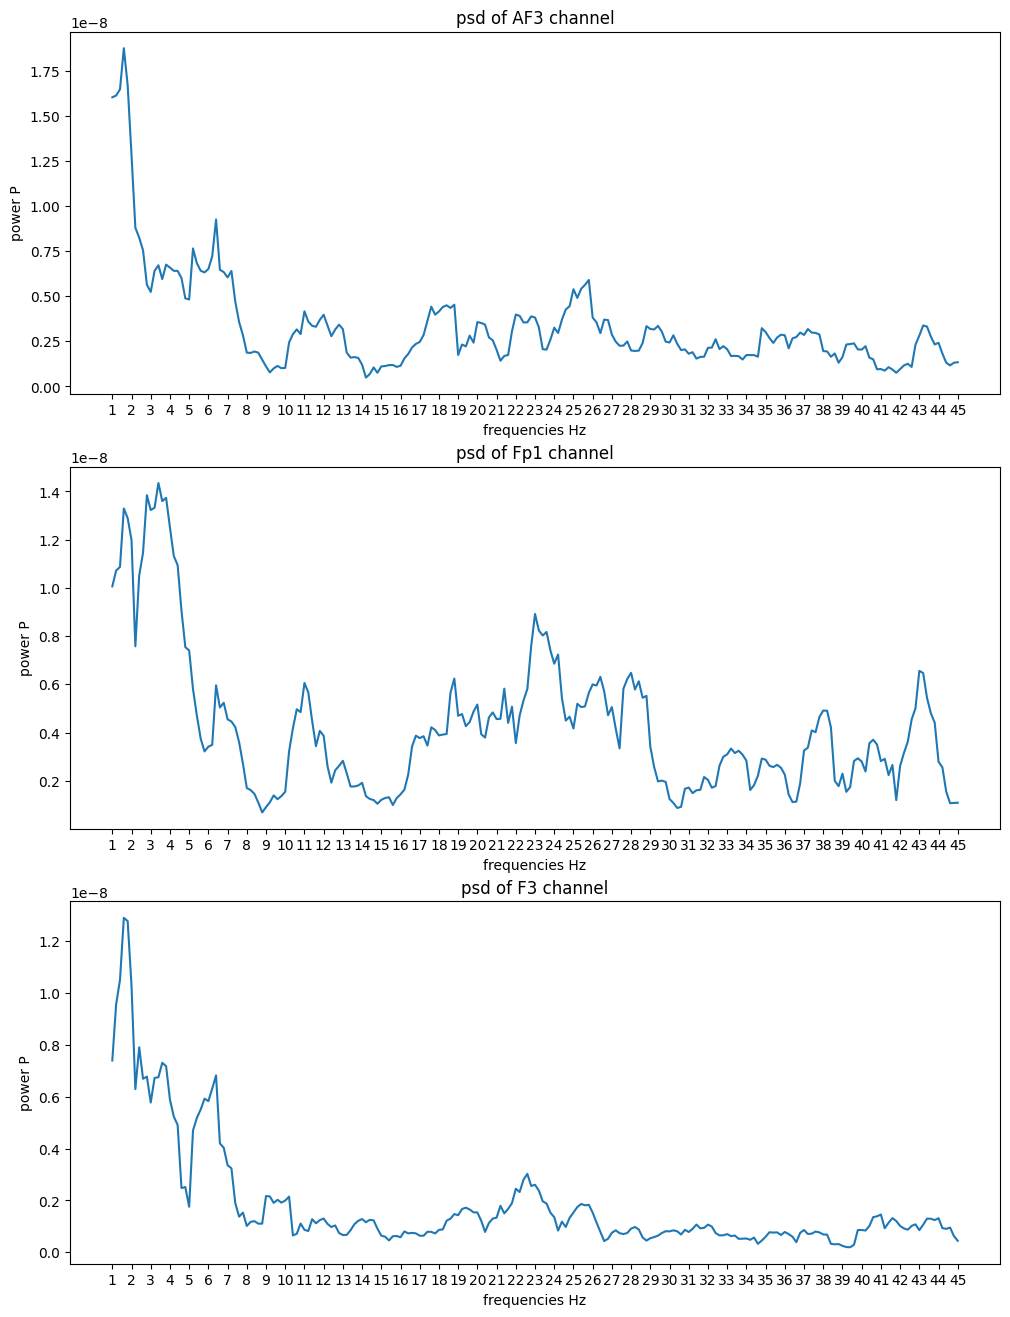

In [42]:
psd1, freqs1 = plot_psd(m1_new, channels_1, figsize=(12, 16))

In [43]:
for i, ch_n in enumerate(channels_1):
    print(f"For channel {ch_n}")
    frequecy_ranges(psd1[i], freqs1)
    print()

For channel AF3
The range delta: 22.343 % of the total power
The range theta: 15.861 % of the total power
The range alpha: 6.338 % of the total power
The range beta: 34.73 % of the total power
The range gamma: 20.728 % of the total power

For channel Fp1
The range delta: 20.623 % of the total power
The range theta: 11.495 % of the total power
The range alpha: 6.078 % of the total power
The range beta: 39.94 % of the total power
The range gamma: 21.864 % of the total power

For channel F3
The range delta: 32.52 % of the total power
The range theta: 19.357 % of the total power
The range alpha: 6.957 % of the total power
The range beta: 26.416 % of the total power
The range gamma: 14.749 % of the total power



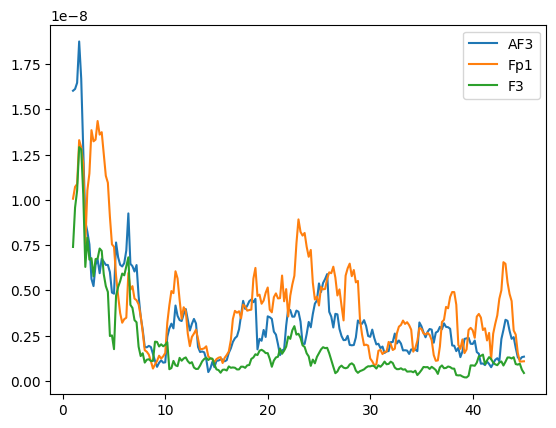

In [44]:
# let's visualize the osciallation of all channels
_, _ = plot_psd(m1_new, channels_1, figsize=(12, 16), all_one=True)

## Activity Conclusion
The simple visualization above indicates that channels AF3 and FP1 dominate
For the 1st human subject, we have the following: 
1. Key range frequency: Beta
2. Cortex: Frontal Lobe

beta activity in the frontal lobe is associated with several cognitive processes, such as working memory, decision-making, and attention control

# File2

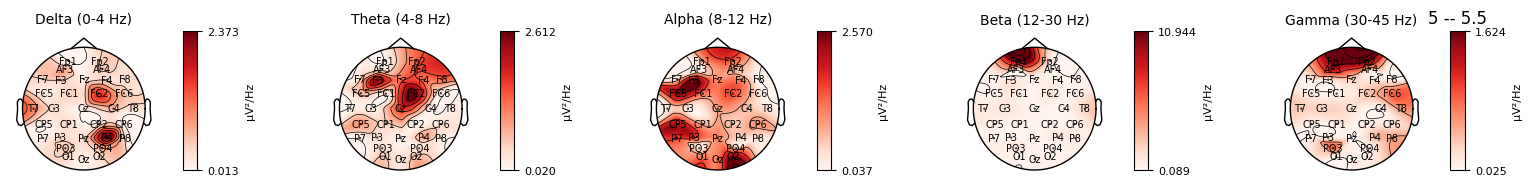

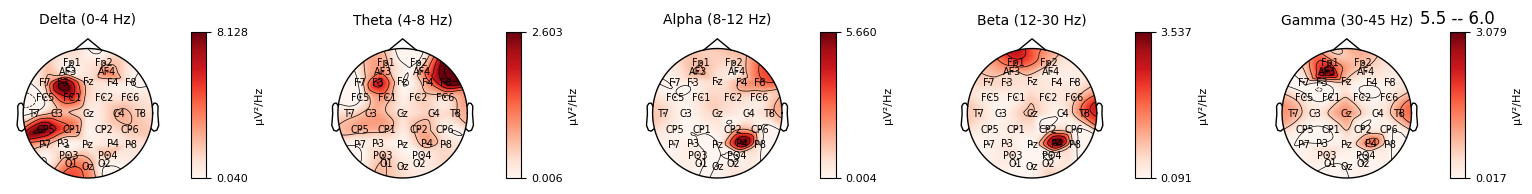

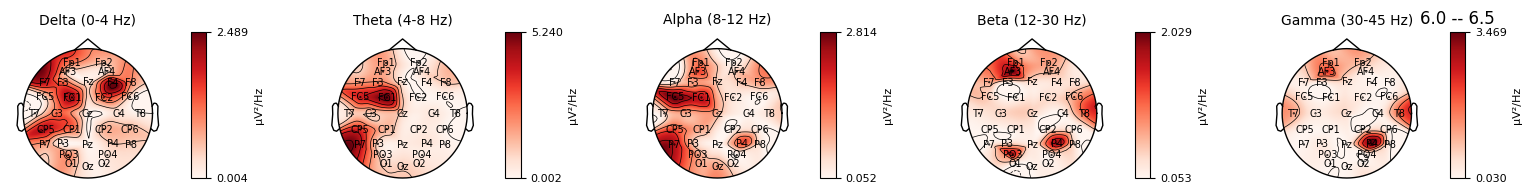

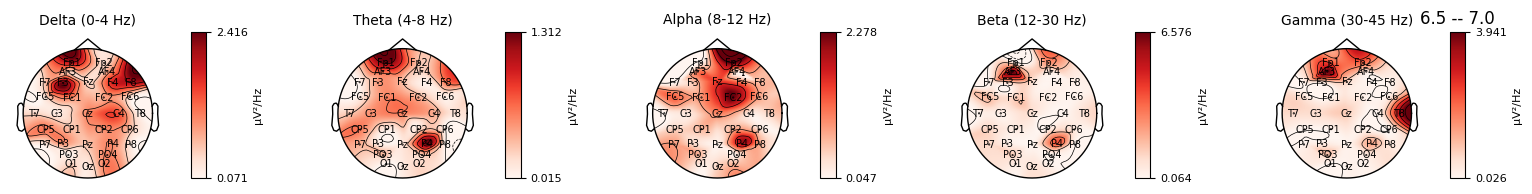

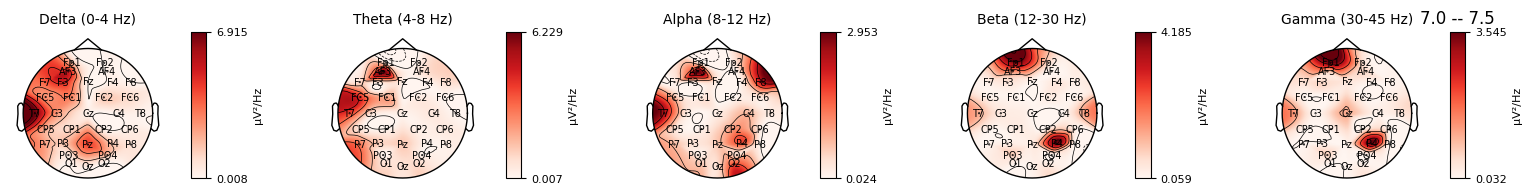

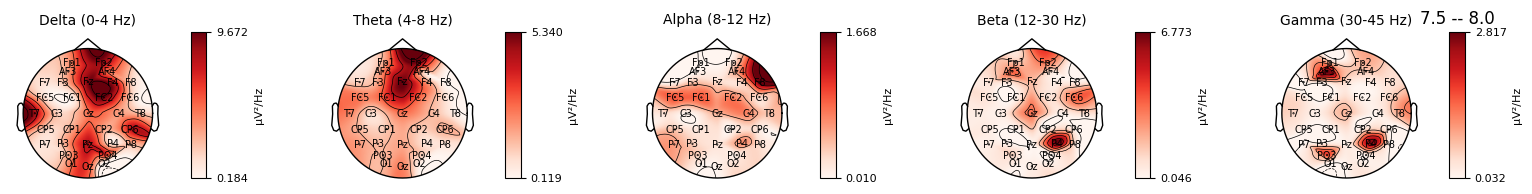

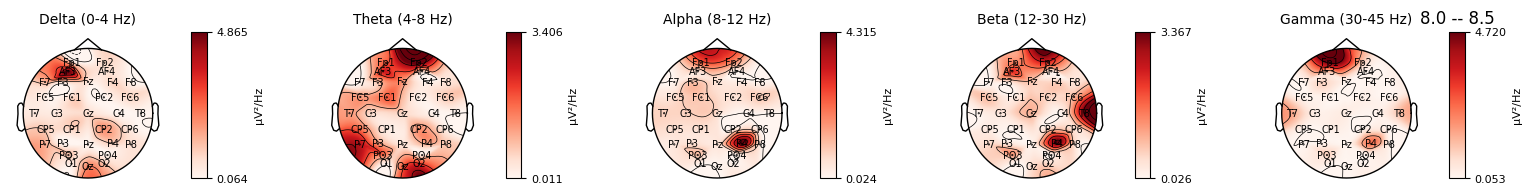

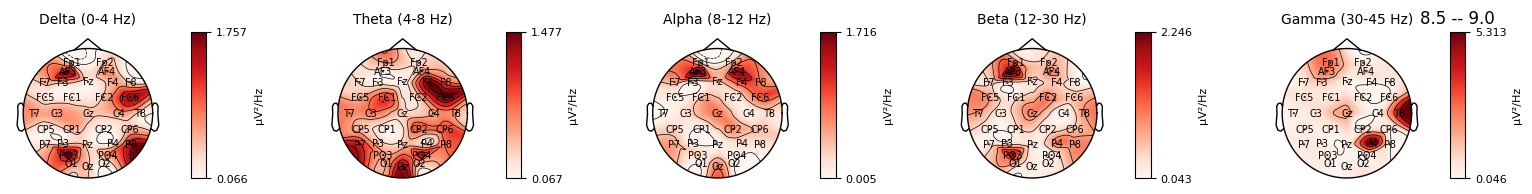

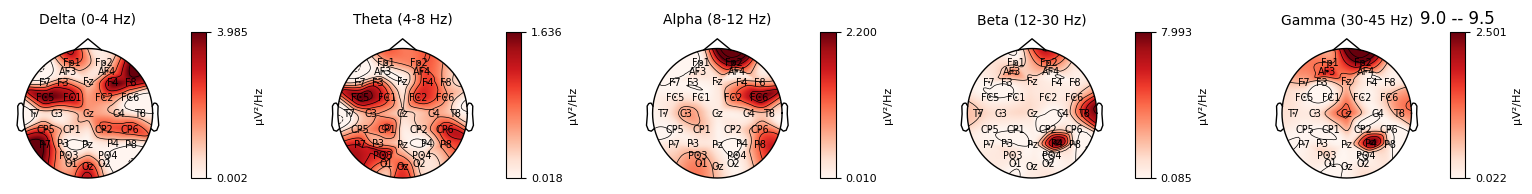

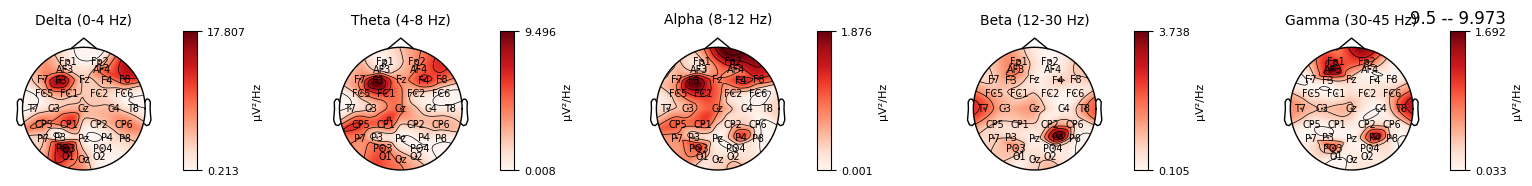

In [45]:
plot_windows(m2, start=5) # starting from the 5-th second (because the first 5 seconds are baseline)

In [46]:
m2_5 = mne2.copy().crop(tmin=5)
areas = pd.Series(np.apply_along_axis(lambda x: auc(x, m2_5.times), 1, m2_5._data), index=ch_names)
areas.sort_values()

C4     0.000019
CP6    0.000019
CP2    0.000020
O1     0.000020
Pz     0.000021
P8     0.000021
Oz     0.000021
O2     0.000021
PO4    0.000021
P3     0.000022
F4     0.000023
CP1    0.000023
FC2    0.000023
F8     0.000024
C3     0.000025
CP5    0.000025
P7     0.000025
FC6    0.000025
AF4    0.000026
F7     0.000026
FC1    0.000026
Fz     0.000028
FC5    0.000029
F3     0.000031
T7     0.000032
Cz     0.000035
Fp2    0.000039
PO3    0.000040
T8     0.000049
AF3    0.000051
Fp1    0.000052
P4     0.000071
dtype: float64

In [61]:
channels_2 = ['AF3', 'Fp1', 'F4']
m2_new = extract_channels(m2_5, channels_2)
# let's proceed to consider the correlation:
df2_data = pd.DataFrame(m2_new._data, index=channels_2)
df2_data.T.corr()

[ 0  1 26]


AF3       Fp1        F4
AF3  1.000000 -0.077718 -0.048235
Fp1 -0.077718  1.000000  0.018392
F4  -0.048235  0.018392  1.000000

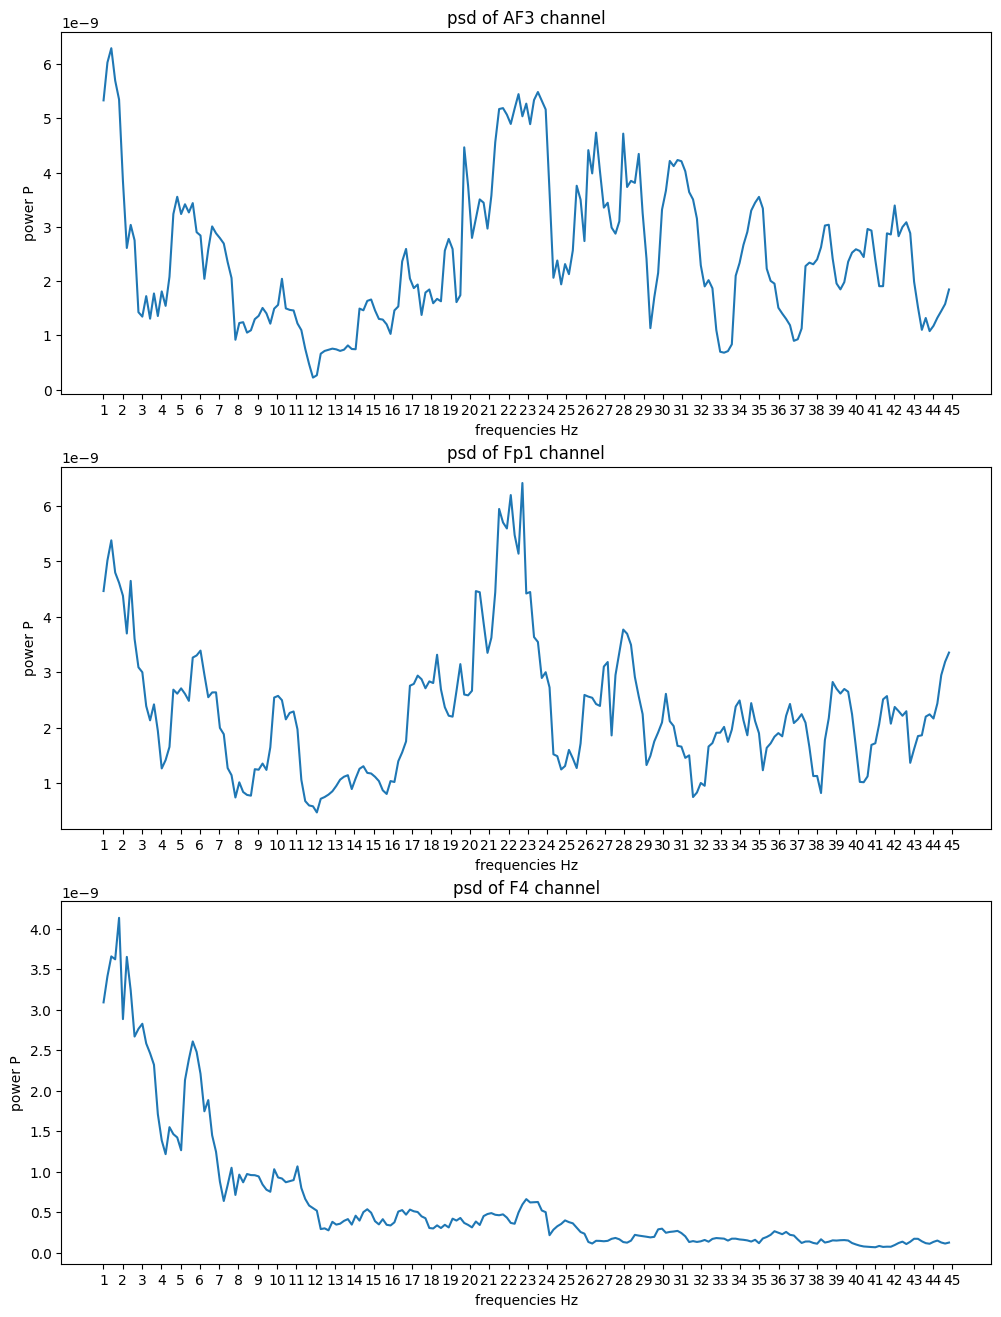

In [48]:
psd2, freqs2 = plot_psd(m2_new, channels_2, figsize=(12, 16))

In [49]:
for i, ch_n in enumerate(channels_2):
    print(f"For channel {ch_n}")
    frequecy_ranges(psd2[i], freqs2)
    print()

For channel AF3
The range delta: 9.109 % of the total power
The range theta: 9.616 % of the total power
The range alpha: 4.504 % of the total power
The range beta: 45.518 % of the total power
The range gamma: 31.252 % of the total power

For channel Fp1
The range delta: 11.094 % of the total power
The range theta: 9.019 % of the total power
The range alpha: 5.851 % of the total power
The range beta: 45.224 % of the total power
The range gamma: 28.812 % of the total power

For channel F4
The range delta: 33.04 % of the total power
The range theta: 22.42 % of the total power
The range alpha: 12.628 % of the total power
The range beta: 23.687 % of the total power
The range gamma: 8.225 % of the total power



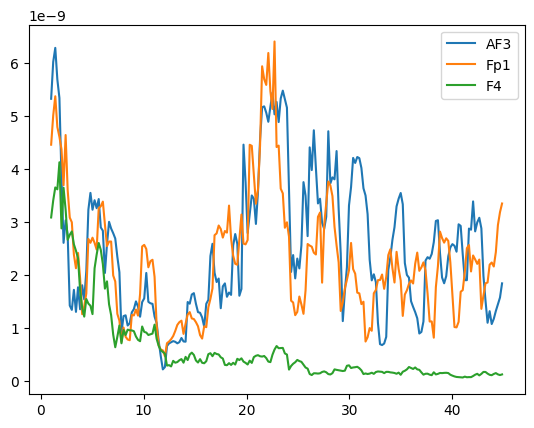

In [50]:
# let's display the power differently to see the dominant channels
psd2, freqs2 = plot_psd(m2_new, channels_2, figsize=(12, 16), all_one=True)

Even though the channel F4 has a dominant frequency range Delta, the other two have a dominant frequency range Beta.  

Thus, we can conclude that for the 2nd human subject's:
1. Frequency key range: Beta
2. Location in the brain: Front Lobe


# Statistical test on two activity slices


The statistical test will be conducted as follows:
1. extract slice of both activities
2. The values of the different channels for the 1st human subject will be averaged together
3. The values of the different channels for the 2nd human subject will be averaged together
4. the statistical test t-test will be used to test whether the means of the samples are the same or not: (which can be approximated to whether the activities are statistically different or not)

In [51]:
from numpy.random import seed
from numpy.random import randn
from numpy.random import normal
from scipy.stats import ttest_ind

In [60]:
data1 = m1_new._data[:, :4000]
data2 = m2_new._data[:, :4000]
# let's average out all channels
data1 = np.mean(data1, axis=0).T
data2 = np.mean(data2, axis=0).T

print(data1.shape)
print(data2.shape)

# before applying t-test, it might be better to divide by the variance to guarantee both series have a variance of 1
std1 = np.std(data1) 
std2 = np.std(data2) 

# now the data should is a sample
sample1 = (data1) / std1  
sample2 = (data2) / std2 

# taken the number of values is 4k, we can approximate the data to normal distribution
# and thus the conditions for the t-test are satisfied

t_stat, p_value = ttest_ind(sample1, sample2)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)


(4000,)
(4000,)
T-statistic value:  -2.502486411238722
P-Value:  0.012352233673215687


We can see that the p-value is less than 0.05.   
We can safely assume the brain activities of the 2 human subjects are indeed different.